# 通道策略
*用Python量化你的技术分析*

## 目录
- 通道是什么？
- 不同通道是怎么计算的？
- 通道如何用图表显示？
- 如何用通道构建策略？

## 通道是什么？
通道突破是技术分析中一个判断趋势的重要方法，其观念在于市场价格穿透了之前的价格压力或支撑，继而形成一股新的趋势，而交易策略的目标即是在突破发生时能够确认并建立仓位以获取趋势的利润。

## 不同通道是怎么计算的？
---
### 1. 均线百分比通道

$Upper = MA*1.03$

$lower = MA*0.97$

---

### 2. 布林带通道
$upper = MA+2\sigma$

$lower = MA-2\sigma$

---

### 3. 平均波幅通道
$upper = MA + ATR$

$lower = MA - ATR$

---

### 4. 高低价通道
$upper = Max(High,20)$

$lower = Min(low,20)$

## 通道如何用图表显示？

In [1]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import talib as ta
from talib import abstract

warnings.filterwarnings('ignore')

data = pd.read_excel('three.xlsx', sheetname='BTCUSDT.binance', index_col='datetime').iloc[-300:]

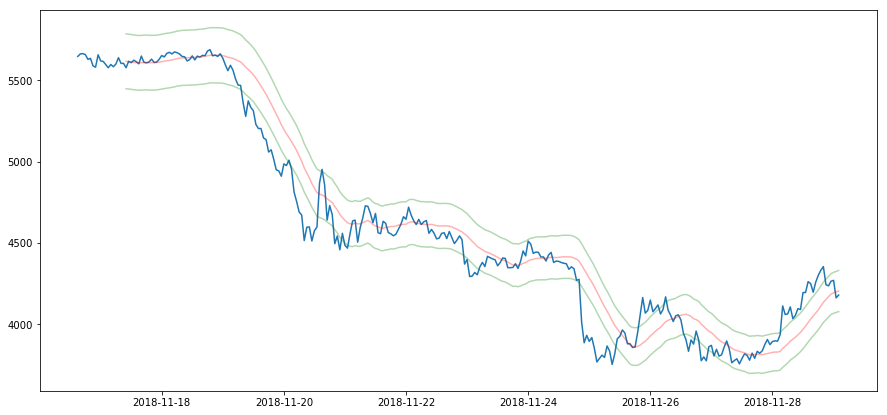

In [2]:
#均线百分比通道
middleband = abstract.MA(data, timeperiod=20)
upperband = middleband*1.03
lowerband = middleband*0.97
data_B = pd.concat([middleband, upperband , lowerband], axis=1)
data_B.columns = ['middleband','upperband','lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

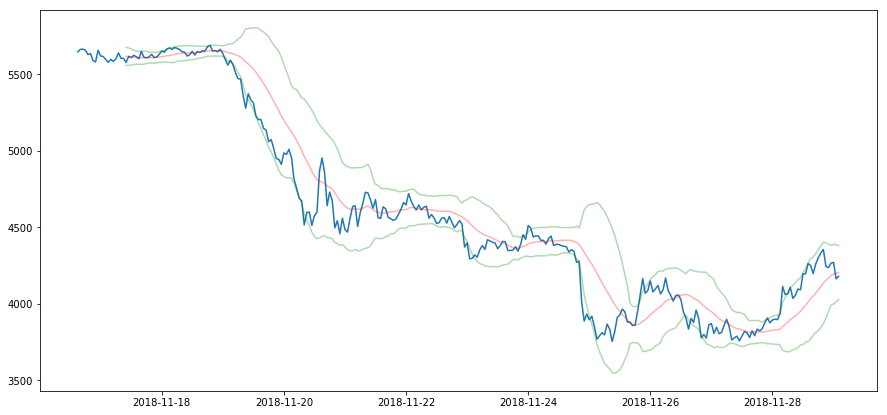

In [3]:
#布林带
data_B= abstract.BBANDS(data, timeperiod=20)

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

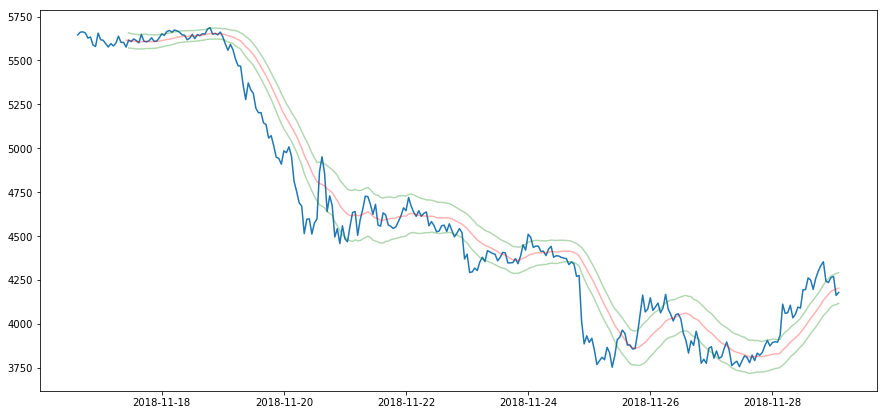

In [4]:
#平均波幅率通道线
atr = abstract.ATR(data, 20)
middleband = abstract.MA(data, 20)
upperband = middleband + atr
lowerband = middleband - atr
data_B = pd.concat([middleband, upperband, lowerband], axis=1)
data_B.columns = ['middleband', 'upperband', 'lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

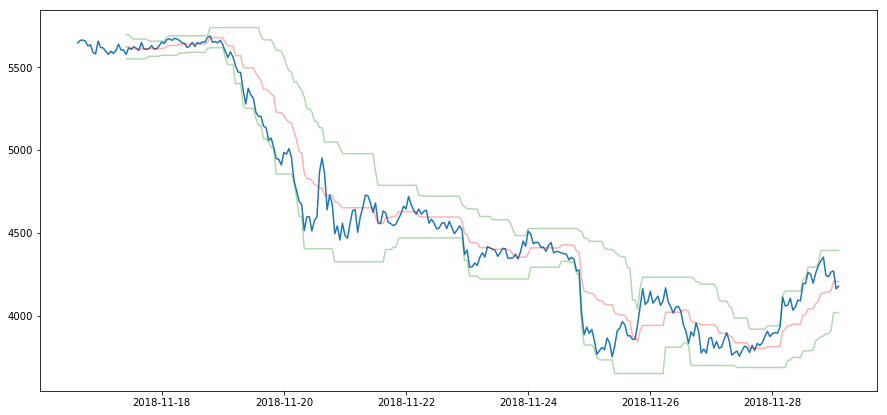

In [5]:
#高低价通道
upperband = abstract.MAX(data, 20, price='high')
lowerband = abstract.MIN(data, 20, price='low')
middleband = (upperband+lowerband)/2
data_B = pd.concat([middleband, upperband, lowerband], axis=1)
data_B.columns = ['middleband', 'upperband', 'lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

## 如何用通道构建策略？
### 1. Bollinger Band

Buy： 价格突破UpperBand 和 Sigma<0.005

Sell： b%>0.05

In [ ]:
# 参数设置
lowVolThrehold = 0.005; highVolThrehold = 0.05
BBandPeriod = 20
lot = 1

# 指标计算
up, mid, low = ta.BBANDS(am.close, self.BBandPeriod)
sigma = (up -  mid) / (2 *  mid)

# 现象条件
breakUp = (am.close[-2] <= up[-2]) and (am.close[-1] > up[-2])
breakDn = (am.close[-2] <= low[-2]) and (am.close[-1] > low[-2])
        
# 进出场条件
if breakUp and (sigma < self.lowVolThrehold) and (self.posDict[symbol + "_LONG"]==0):
    if self.posDict[symbol + "_SHORT"] == 0:
        self.buy(symbol, bar.close * 1.01, self.lot)
    elif self.posDict[symbol + "_SHORT"] > 0:
        self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
        self.buy(symbol, bar.close * 1.01, self.lot)

elif breakDn and (sigma < self.lowVolThrehold) and (self.posDict[symbol + "_SHORT"]==0):
    if self.posDict[symbol + "_LONG"] == 0:
        self.short(symbol, bar.close * 0.99, self.lot)
    elif self.posDict[symbol + "_LONG"] > 0:
        self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
        self.short(symbol, bar.close *0.99, self.lot)

if sigma>highVolThrehold:
    if self.posDict[symbol + "_LONG"] > 0:
        self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
    elif self.posDict[symbol + "_SHORT"] > 0:
        self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

# 作业：
写一个高低价通道突破策略